In [1]:
import sys, os
import torch
import visdom
import argparse
import timeit
import numpy as np
import scipy.misc as misc
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

from torch.autograd import Variable
from torch.utils import data
from tqdm import tqdm

from ptsemseg.models import get_model
from ptsemseg.loader import get_loader, get_data_path
from ptsemseg.utils import convert_state_dict

%matplotlib inline
import matplotlib.pyplot as plt

from SUNRGBDLoader import *
from SUNRGBDLoader_HHA import *

In [2]:
parser = argparse.ArgumentParser(description='Params')
parser.add_argument('--model_path', nargs='?', type=str, default='fcn8s_pascal_1_26.pkl', help='Path to the saved model')
parser.add_argument('--model_name', nargs='?', type=str, help='model name')
parser.add_argument('--dataset', nargs='?', type=str, default='pascal', help='Dataset to use [\'pascal, camvid, ade20k etc\']')

parser.add_argument('--img_norm', dest='img_norm', action='store_true', help='Enable input image scales normalization [0, 1] | True by default')
parser.add_argument('--no-img_norm', dest='img_norm', action='store_false', help='Disable input image scales normalization [0, 1] | True by default')
parser.set_defaults(img_norm=True)

parser.add_argument('--dcrf', dest='dcrf', action='store_true', help='Enable DenseCRF based post-processing | False by default')
parser.add_argument('--no-dcrf', dest='dcrf', action='store_false', help='Disable DenseCRF based post-processing | False by default')
parser.set_defaults(dcrf=False)

parser.add_argument('--color_path', nargs='?', type=str, default=None, help='Path of the input color image')
parser.add_argument('--depth_path', nargs='?', type=str, default=None, help='Path of the input depth image')
parser.add_argument('--out_path', nargs='?', type=str, default=None, help='Path of the output segmap')

_StoreAction(option_strings=['--out_path'], dest='out_path', nargs='?', const=None, default=None, type=<class 'str'>, choices=None, help='Path of the output segmap', metavar=None)

In [65]:
def test(args):
    model_file_name = os.path.split(args.model_path)[1]
    model_name = args.model_name

    # Setup image
    print("Read Input color image from : {}".format(args.color_path))
    img = misc.imread(args.color_path)
    if (args.depth_path is not None):
        print("Read Input depth image from : {}".format(args.depth_path))
        depth_img = misc.imread(args.depth_path)
    
    if (args.dataset == 'NYUDv2'):
        data_path = '/home/dongwonshin/Desktop/Datasets/NYUDv2/'
        loader = NYUDv2Loader(data_path, is_transform=True, split='val')
    elif (args.dataset == 'NYUDv2_HHA'):
        data_path = '/home/dongwonshin/Desktop/Datasets/NYUDv2/'
        loader = NYUDv2Loader_HHA(data_path, is_transform=True, split='val')
    elif (args.dataset == 'SUNRGBD'):
        data_path = '/home/dongwonshin/Desktop/Datasets/SUNRGBD/SUNRGBD/'
        loader = SUNRGBDLoader(data_path, is_transform=True, split='val')
    elif (args.dataset == 'SUNRGBD_HHA'):
        data_path = '/home/dongwonshin/Desktop/Datasets/SUNRGBD/SUNRGBD/'
        loader = SUNRGBDLoader_HHA(data_path, is_transform=True, split='val')
    
    n_classes = loader.n_classes
    
    # preprocessing
    resized_img = misc.imresize(img, (loader.img_size[0], loader.img_size[1]), interp='bicubic')
    orig_size = img.shape[:-1]
    img = misc.imresize(img, (loader.img_size[0], loader.img_size[1]))
    img = img[:, :, ::-1]
    img = img.astype(np.float64)
    img -= loader.mean
    if args.img_norm:
        img = img.astype(float) / 255.0
    # NHWC -> NCHW
    img = img.transpose(2, 0, 1)
    img = np.expand_dims(img, 0)
    img = torch.from_numpy(img).float()

    if (args.depth_path is not None):
        depth_img = m.imresize(depth_img, (loader.img_size[0], loader.img_size[1]))
        depth_img = depth_img.astype(np.float64)
        if (args.dataset not in ['NYUDv2_HHA','SUNRGBD_HHA']):
            depth_img = depth_img[np.newaxis,:]
        depth_img -= loader.depth_mean
        if args.img_norm:
            # Resize scales images from 0 to 255, thus we need
            # to divide by 255.0
            depth_img = depth_img.astype(float) / 255.0
#         depth_img = depth_img.transpose(2, 0, 1)
        depth_img = np.expand_dims(depth_img, 0)
        depth_img = torch.from_numpy(depth_img).float()
    
    
    # Setup Model
    model = get_model(model_name, n_classes, version=args.dataset)
    state = convert_state_dict(torch.load(args.model_path)['model_state'])
    model.load_state_dict(state)
    model.eval()

    model.cuda(0)
    images = Variable(img.cuda(0), volatile=True)
    if (args.depth_path is not None):
        depths = Variable(depth_img.cuda(0), volatile=True)

    if (model_name in ['FCN_RGB', 'FCN_RGB_renet', 'FCN_RGB_mask2']):
        outputs = model(images)
    else:
        outputs = model(images, depths)
    #outputs = F.softmax(outputs, dim=1)

    pred = np.squeeze(outputs.data.max(1)[1].cpu().numpy(), axis=0)
    decoded = loader.decode_segmap(pred)
    print('Classes found: ', np.unique(pred))
    plt.imshow(decoded)
    plt.imsave(os.path.join('../inference_result/output_images/SUNRGBD/','%s_%s.png' % (args.model_name,args.dataset)), decoded)
    print("Segmentation Mask Saved at: {}".format(args.out_path))
    

Read Input color image from : ../inference_result/input_images/SUNRGBD/test_color.jpg


/home/dongwonshin/.conda/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1462: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.")


Classes found:  [ 0  1  2  3  4  5 11 17 18 19 21 22 26 27 35 37]
Segmentation Mask Saved at: None


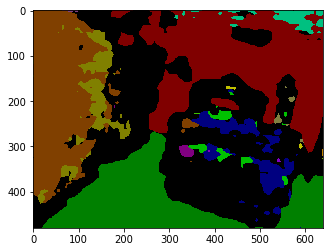

In [4]:
test(parser.parse_args('--model_path ../model_weights/FCN_RGB_SUNRGBD_best_model.pkl ' \
                       '--model_name FCN_RGB ' \
                       '--dataset SUNRGBD ' \
                       '--color_path ../inference_result/input_images/SUNRGBD/test_color.jpg'.split(' ')))

Read Input color image from : ../inference_result/input_images/SUNRGBD/test_color.jpg


/home/dongwonshin/.conda/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1462: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.")


Classes found:  [ 0  1  2  3  4 17 21 22]
Segmentation Mask Saved at: None


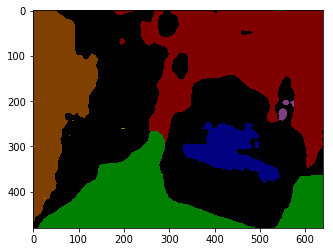

In [5]:
test(parser.parse_args('--model_path ../model_weights/FCN_RGB_renet_SUNRGBD_best_model.pkl ' \
                       '--model_name FCN_RGB_renet ' \
                       '--dataset SUNRGBD ' \
                       '--color_path ../inference_result/input_images/SUNRGBD/test_color.jpg'.split(' ')))

Read Input color image from : ../inference_result/input_images/SUNRGBD/test_color.jpg


/home/dongwonshin/.conda/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1462: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.")


Classes found:  [ 0  1  2  3  4  5  9 13 17 18 22 35]
Segmentation Mask Saved at: None


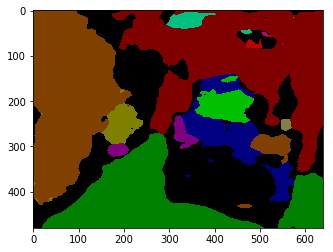

In [6]:
test(parser.parse_args('--model_path ../model_weights/FCN_RGB_mask2_SUNRGBD_best_model.pkl ' \
                       '--model_name FCN_RGB_mask2 ' \
                       '--dataset SUNRGBD ' \
                       '--color_path ../inference_result/input_images/SUNRGBD/test_color.jpg'.split(' ')))

Read Input color image from : ../inference_result/input_images/SUNRGBD/test_color.jpg
Read Input depth image from : ../inference_result/input_images/SUNRGBD/test_depth.png


/home/dongwonshin/.conda/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1462: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.")


Classes found:  [ 0  1  2  3  4  5  9 16 17 18 19 21 22 31 32 35 37]
Segmentation Mask Saved at: None


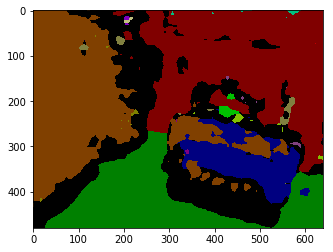

In [7]:
test(parser.parse_args('--model_path ../model_weights/FCN_RGBD_SUNRGBD_best_model.pkl ' \
                       '--model_name FCN_RGBD ' \
                       '--dataset SUNRGBD ' \
                       '--color_path ../inference_result/input_images/SUNRGBD/test_color.jpg ' \
                       '--depth_path ../inference_result/input_images/SUNRGBD/test_depth.png'.split(' ')))

Read Input color image from : ../inference_result/input_images/SUNRGBD/test_color.jpg
Read Input depth image from : ../inference_result/input_images/SUNRGBD/test_depth.png


/home/dongwonshin/.conda/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1462: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.")


Classes found:  [ 0  1  2  3  4 17 19 22]
Segmentation Mask Saved at: None


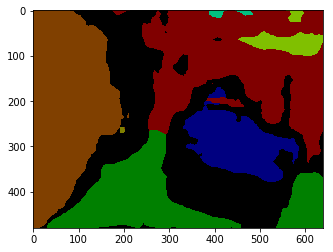

In [8]:
test(parser.parse_args('--model_path ../model_weights/FCN_RGBD_renet_SUNRGBD_best_model.pkl ' \
                       '--model_name FCN_RGBD_renet ' \
                       '--dataset SUNRGBD ' \
                       '--color_path ../inference_result/input_images/SUNRGBD/test_color.jpg ' \
                       '--depth_path ../inference_result/input_images/SUNRGBD/test_depth.png'.split(' ')))

Read Input color image from : ../inference_result/input_images/SUNRGBD/test_color.jpg
Read Input depth image from : ../inference_result/input_images/SUNRGBD/test_depth.png


/home/dongwonshin/.conda/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1462: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.")


Classes found:  [ 0  1  2  4 16 17 18 21 22 35]
Segmentation Mask Saved at: None


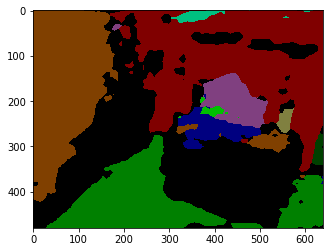

In [13]:
test(parser.parse_args('--model_path ../model_weights/FCN_RGBD_mask2_SUNRGBD_best_model.pkl ' \
                       '--model_name FCN_RGBD_mask2 ' \
                       '--dataset SUNRGBD ' \
                       '--color_path ../inference_result/input_images/SUNRGBD/test_color.jpg ' \
                       '--depth_path ../inference_result/input_images/SUNRGBD/test_depth.png'.split(' ')))

Read Input color image from : ../inference_result/input_images/SUNRGBD/img-000001.jpg
Read Input depth image from : ../inference_result/input_images/SUNRGBD/HHA_000001.png


/home/dongwonshin/.conda/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1462: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.")


Classes found:  [ 0  1  2  3  4  5  8 11 17 18 22 26 35]
Segmentation Mask Saved at: None


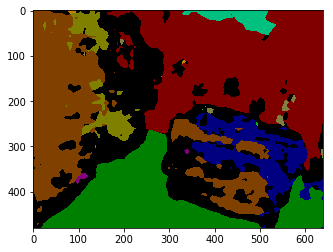

In [8]:
test(parser.parse_args('--model_path ../model_weights/FCN_RGBHHA_SUNRGBD_best_model.pkl ' \
                       '--model_name FCN_RGBHHA ' \
                       '--dataset SUNRGBD_HHA ' \
                       '--color_path ../inference_result/input_images/SUNRGBD/img-000001.jpg ' \
                       '--depth_path ../inference_result/input_images/SUNRGBD/HHA_000001.png'.split(' ')))

Read Input color image from : ../inference_result/input_images/SUNRGBD/img-000001.jpg
Read Input depth image from : ../inference_result/input_images/SUNRGBD/HHA_000001.png


/home/dongwonshin/.conda/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1462: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.")


Classes found:  [ 0  1  2  4 17 19 22 35]
Segmentation Mask Saved at: None


array([[17, 17, 17, ...,  1, 22, 22],
       [17, 17, 17, ...,  1,  1,  1],
       [17, 17, 17, ...,  1,  1,  1],
       ..., 
       [ 0,  0,  0, ...,  2,  2,  2],
       [ 0,  0,  0, ...,  2,  2,  2],
       [ 0,  0,  0, ...,  2,  2,  2]])

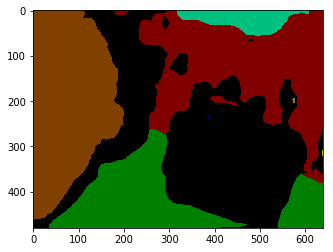

In [5]:
test(parser.parse_args('--model_path ../model_weights/FCN_RGBHHA_renet_SUNRGBD_best_model.pkl ' \
                       '--model_name FCN_RGBHHA_renet ' \
                       '--dataset SUNRGBD_HHA ' \
                       '--color_path ../inference_result/input_images/SUNRGBD/img-000001.jpg ' \
                       '--depth_path ../inference_result/input_images/SUNRGBD/HHA_000001.png'.split(' ')))

Read Input color image from : ../inference_result/input_images/SUNRGBD/img-000001.jpg
Read Input depth image from : ../inference_result/input_images/SUNRGBD/HHA_000001.png


/home/dongwonshin/.conda/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1462: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.")


Classes found:  [ 0  1  2  3  4  5  7  9 16 17 18 21 22 35]
Segmentation Mask Saved at: None


array([[17, 17, 17, ...,  1,  1,  1],
       [17, 17, 17, ...,  1,  1,  1],
       [17, 17, 17, ...,  1,  1,  1],
       ..., 
       [ 0,  0,  0, ...,  2,  2,  2],
       [ 0,  0,  0, ...,  2,  2,  2],
       [ 0,  0,  0, ...,  2,  2,  2]])

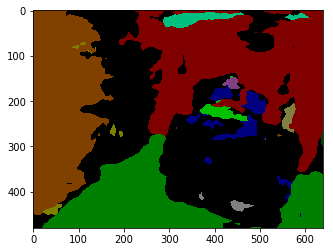

In [6]:
test(parser.parse_args('--model_path ../model_weights/FCN_RGBHHA_mask2_SUNRGBD_best_model.pkl ' \
                       '--model_name FCN_RGBHHA_mask2 ' \
                       '--dataset SUNRGBD_HHA ' \
                       '--color_path ../inference_result/input_images/SUNRGBD/img-000001.jpg ' \
                       '--depth_path ../inference_result/input_images/SUNRGBD/HHA_000001.png'.split(' ')))

Read Input color image from : ../inference_result/input_images/SUNRGBD/img-000001.jpg
Read Input depth image from : ../inference_result/input_images/SUNRGBD/depth_000001.png


/home/dongwonshin/.conda/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1462: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.")


Classes found:  [ 0  1  2  3  4  5  9 13 16 17 18 19 21 22 35]
Segmentation Mask Saved at: None


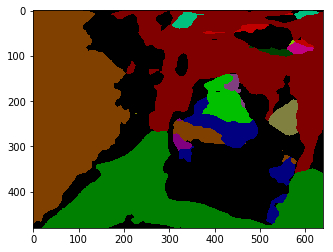

In [66]:
test(parser.parse_args('--model_path ../model_weights/FCN_RGBD_Hybrid_SUNRGBD_best_model.pkl ' \
                       '--model_name FCN_RGBD_Hybrid ' \
                       '--dataset SUNRGBD ' \
                       '--color_path ../inference_result/input_images/SUNRGBD/img-000001.jpg ' \
                       '--depth_path ../inference_result/input_images/SUNRGBD/depth_000001.png'.split(' ')))

Read Input color image from : ../inference_result/input_images/SUNRGBD/img-000001.jpg
Read Input depth image from : ../inference_result/input_images/SUNRGBD/HHA_000001.png


/home/dongwonshin/.conda/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1462: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.")


Classes found:  [ 0  1  2  4  5  7 13 16 17 18 21 22 35]
Segmentation Mask Saved at: None


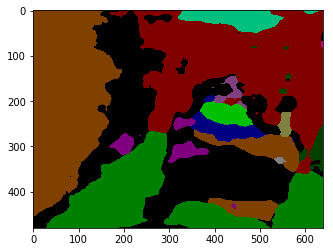

In [62]:
test(parser.parse_args('--model_path ../model_weights/FCN_RGBHHA_Hybrid_SUNRGBD_best_model.pkl ' \
                       '--model_name FCN_RGBHHA_Hybrid ' \
                       '--dataset SUNRGBD_HHA ' \
                       '--color_path ../inference_result/input_images/SUNRGBD/img-000001.jpg ' \
                       '--depth_path ../inference_result/input_images/SUNRGBD/HHA_000001.png'.split(' ')))

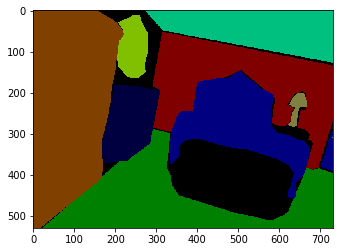

In [20]:
data_path = '/home/dongwonshin/Desktop/Datasets/SUNRGBD/SUNRGBD/'
loader = SUNRGBDLoader(data_path, is_transform=True, split='val')
label_img = misc.imread('../inference_result/input_images/SUNRGBD/label-000001.png')
decoded = loader.decode_segmap(label_img)
plt.imshow(decoded)
plt.imsave('../inference_result/input_images/SUNRGBD/label-000001(decoded).png',decoded)

In [10]:
data_path = '/home/dongwonshin/Desktop/Datasets/SUNRGBD/SUNRGBD/'
loader = SUNRGBDLoader(data_path, is_transform=True, split='val')

#  37 classes

/home/dongwonshin/.conda/envs/pytorch/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


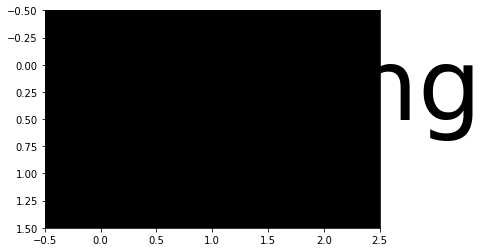

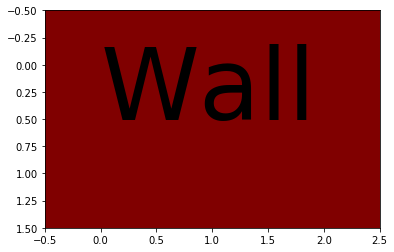

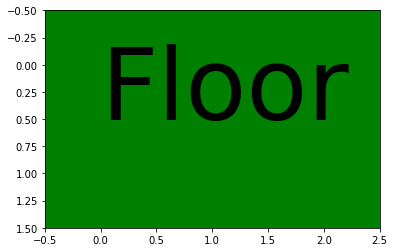

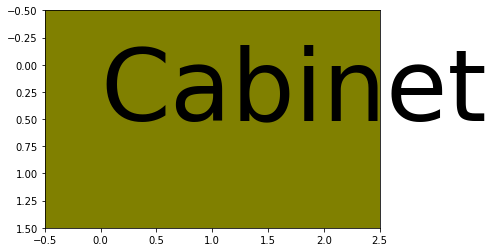

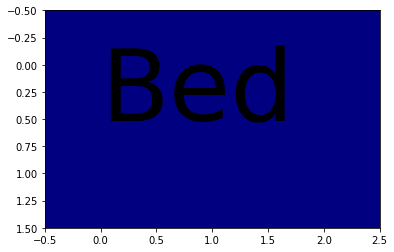

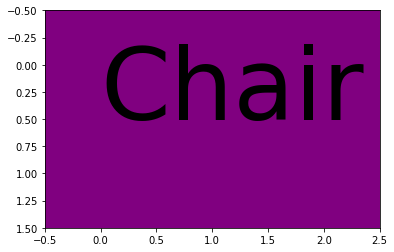

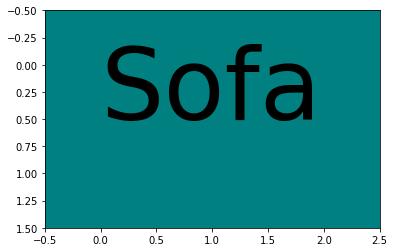

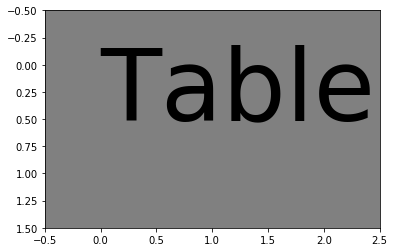

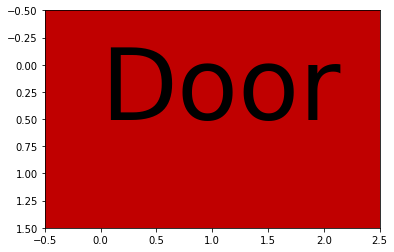

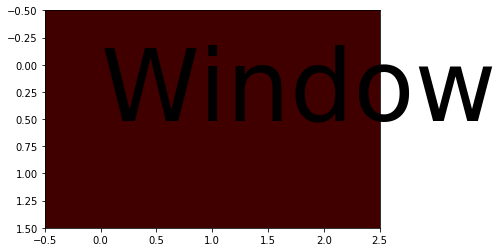

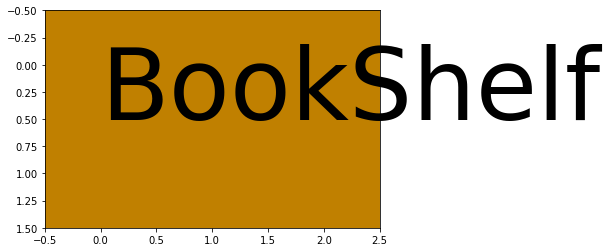

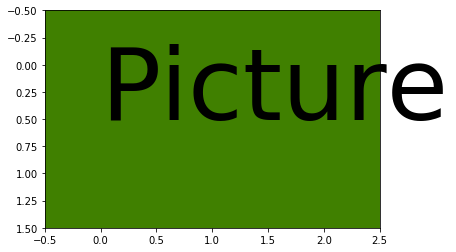

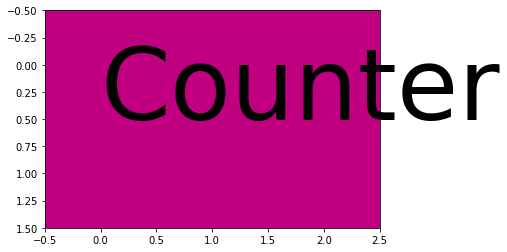

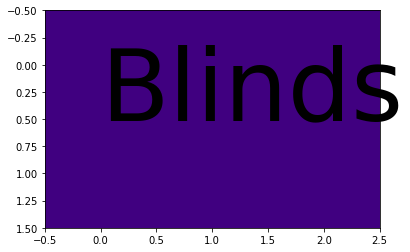

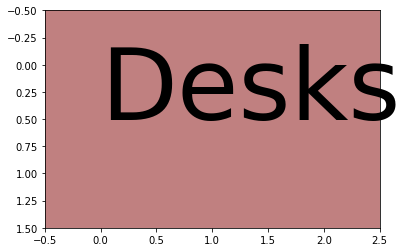

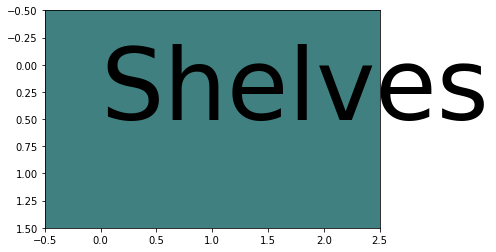

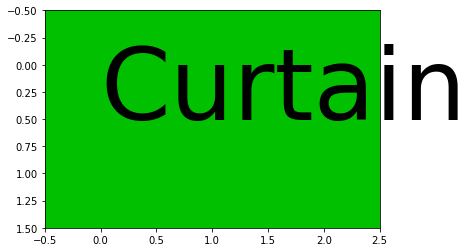

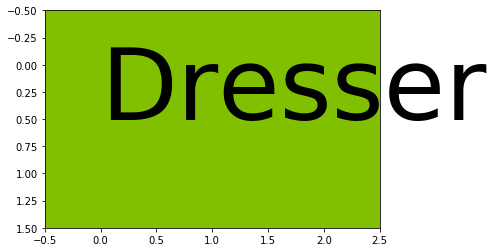

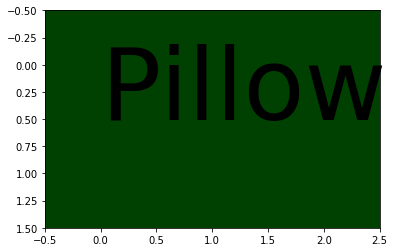

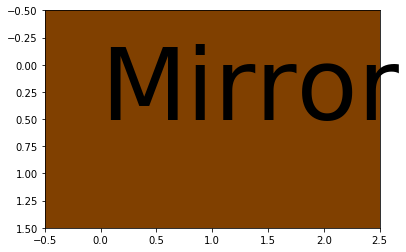

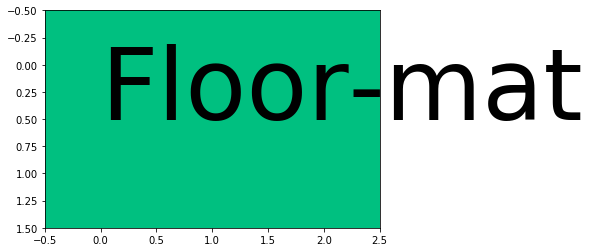

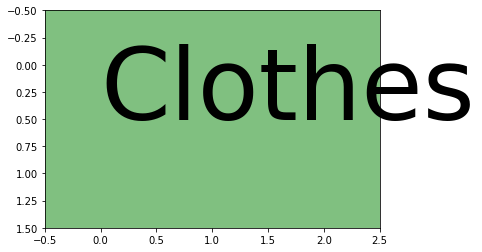

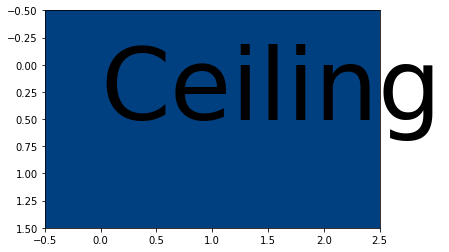

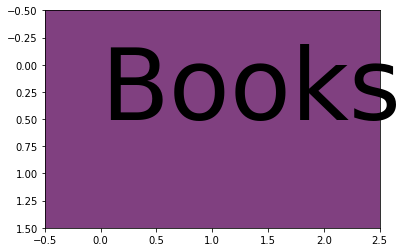

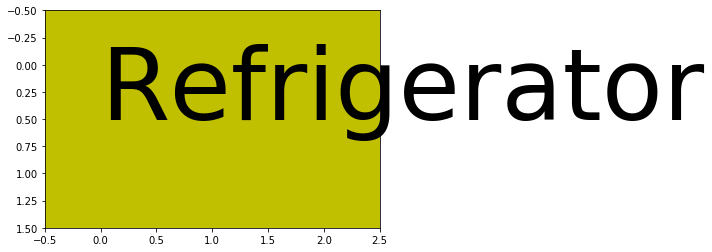

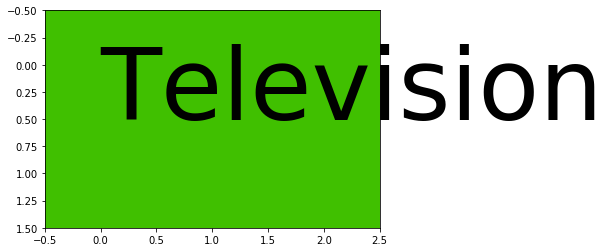

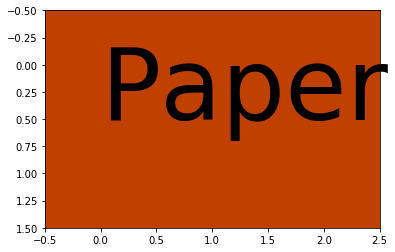

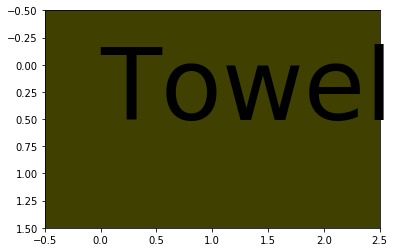

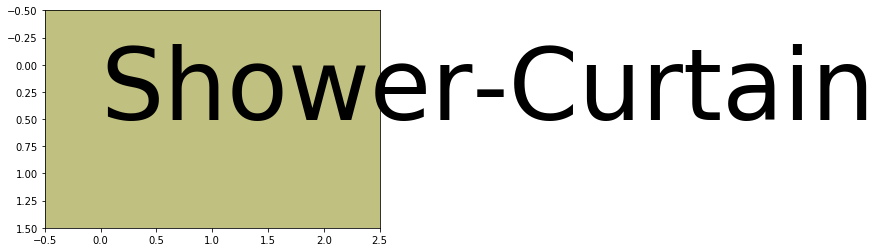

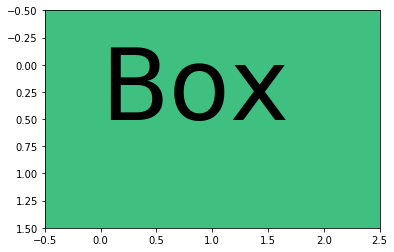

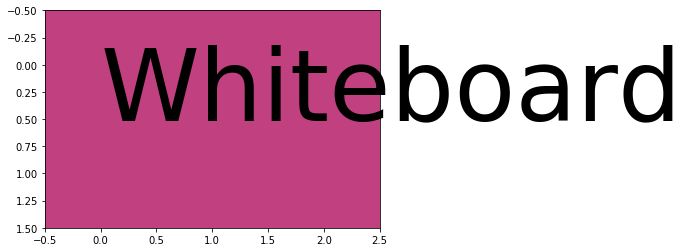

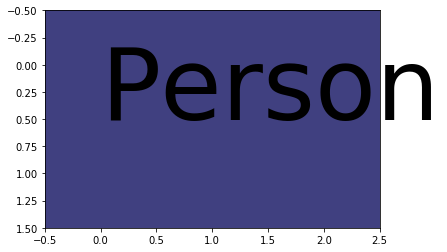

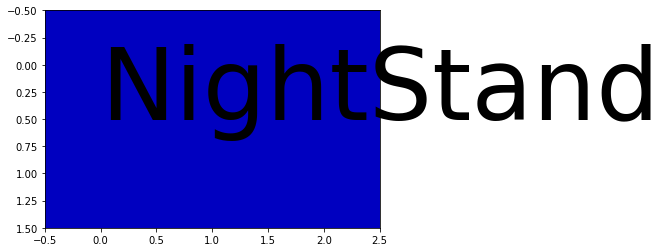

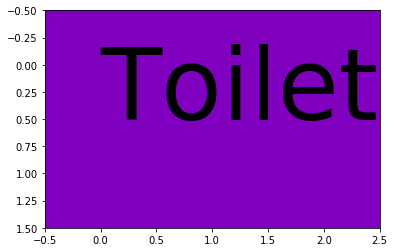

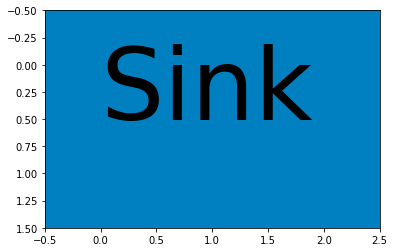

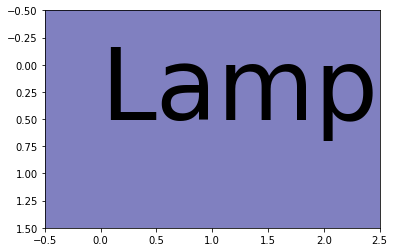

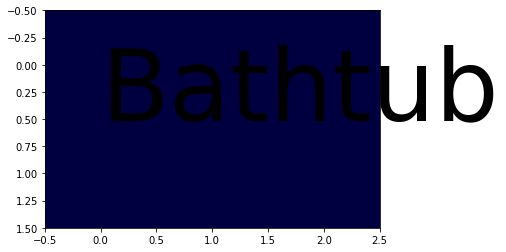

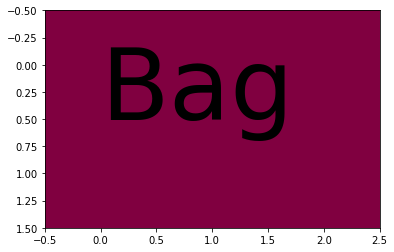

In [68]:
label_texts = ['nothing', 'Wall', 'Floor', 'Cabinet', 'Bed', 'Chair', 'Sofa', 'Table', 'Door',
               'Window', 'BookShelf', 'Picture', 'Counter', 'Blinds', 'Desks', 'Shelves',
               'Curtain', 'Dresser', 'Pillow', 'Mirror', 'Floor-mat', 'Clothes', 'Ceiling',
               'Books', 'Refrigerator', 'Television', 'Paper', 'Towel', 'Shower-Curtain', 'Box',
               'Whiteboard', 'Person', 'NightStand', 'Toilet', 'Sink', 'Lamp', 'Bathtub','Bag']
for i in range(len(label_texts)):
    temp = np.ones((2,3,3))
    temp *= loader.cmap[i]
    plt.figure()
    plt.text(0,0.5,label_texts[i],fontsize=100)
    plt.imshow(temp, aspect='auto')

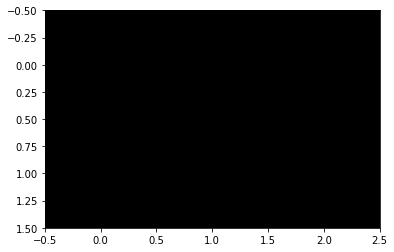

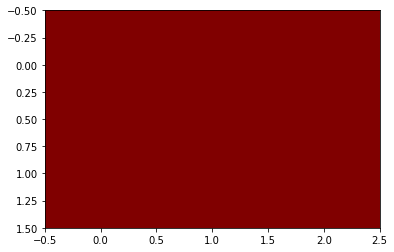

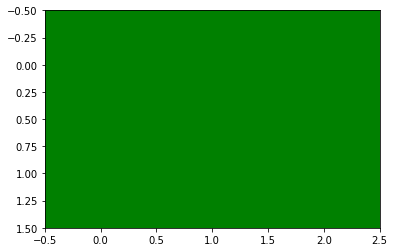

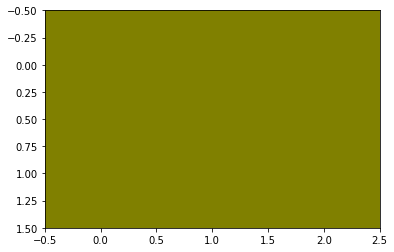

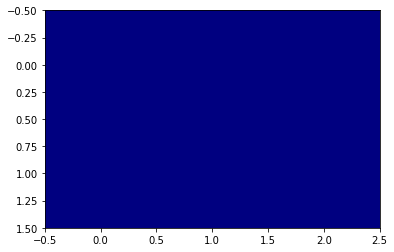

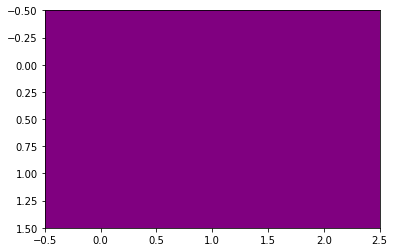

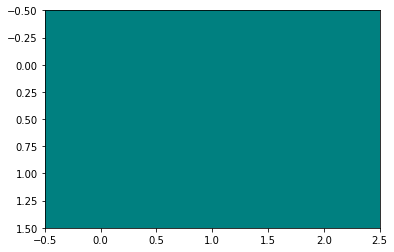

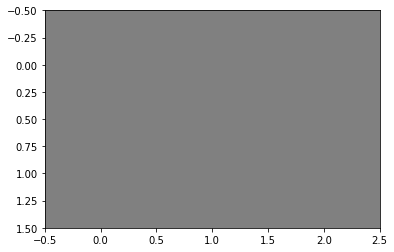

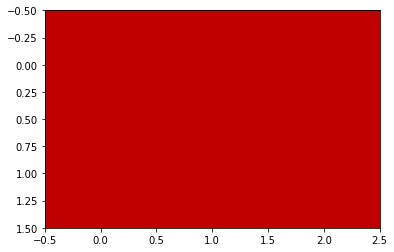

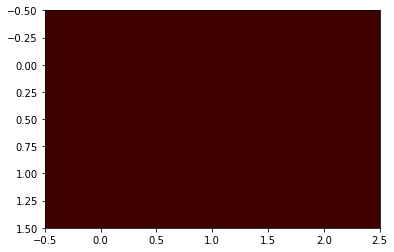

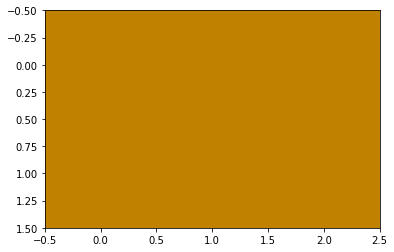

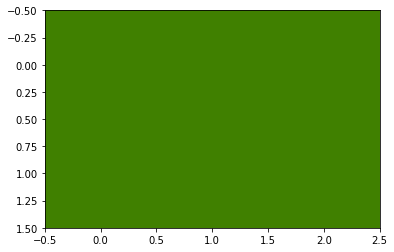

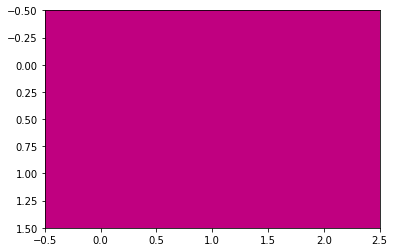

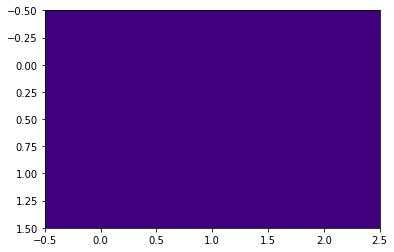

In [71]:
for i in range(len(label_texts)):
    temp = np.ones((2,3,3))
    temp *= loader.cmap[i]
    plt.figure()
    plt.imshow(temp, aspect='auto')

# 13 classes

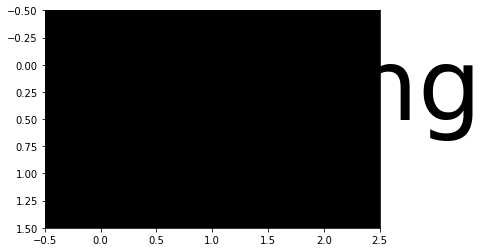

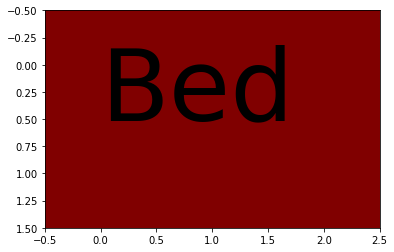

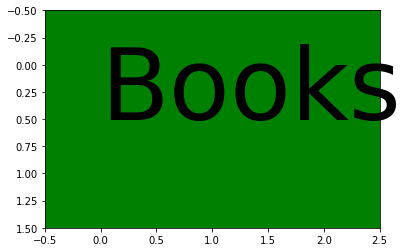

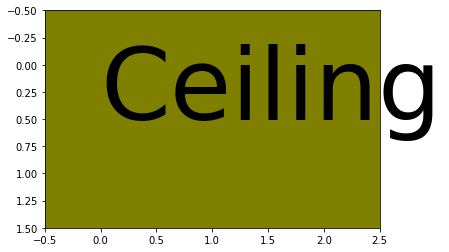

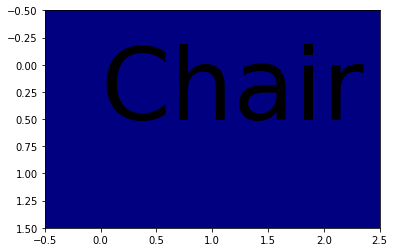

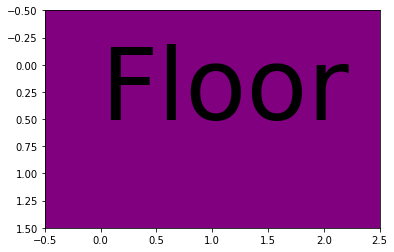

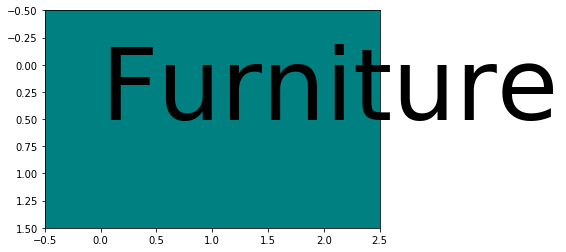

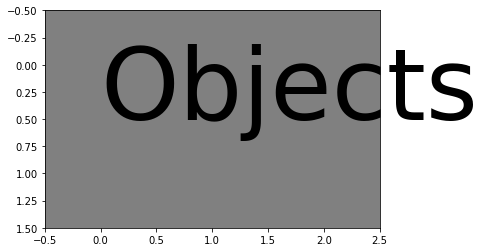

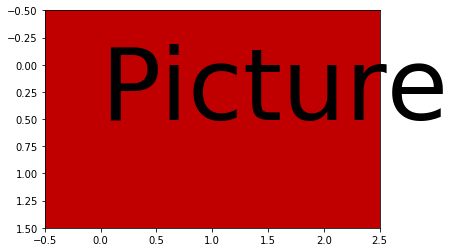

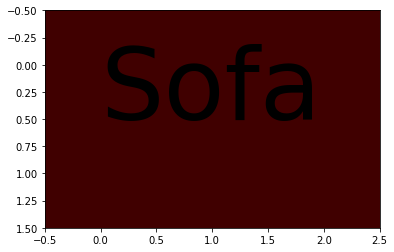

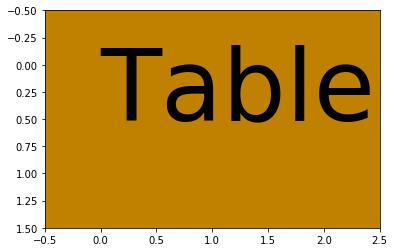

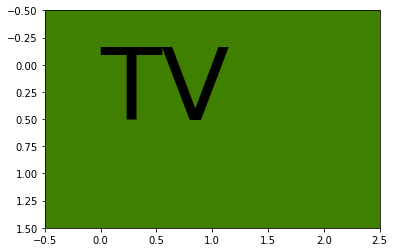

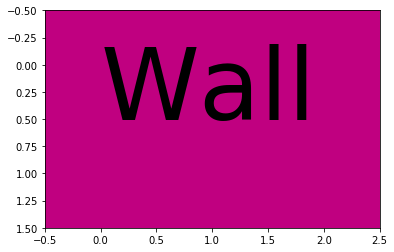

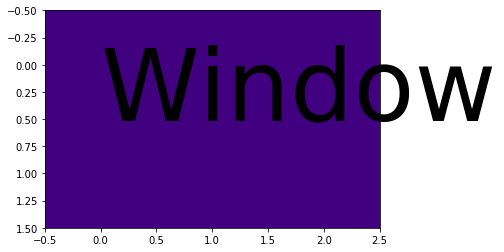

In [73]:
label_texts = ['nothing', 'Bed', 'Books', 'Ceiling', 'Chair', 'Floor', 'Furniture', 'Objects',
               'Picture', 'Sofa', 'Table', 'TV', 'Wall', 'Window']
for i in range(len(label_texts)):
    temp = np.ones((2,3,3))
    temp *= loader.cmap[i]
    plt.figure()
    plt.text(0,0.5,label_texts[i],fontsize=100)
    plt.imshow(temp, aspect='auto')

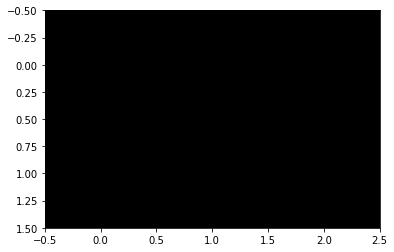

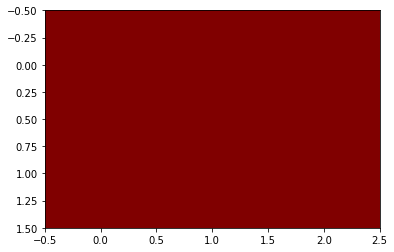

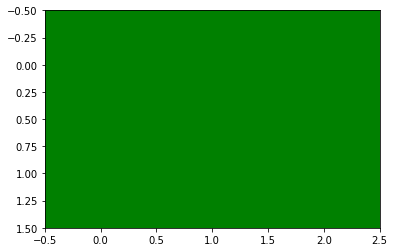

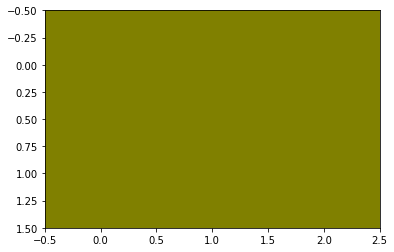

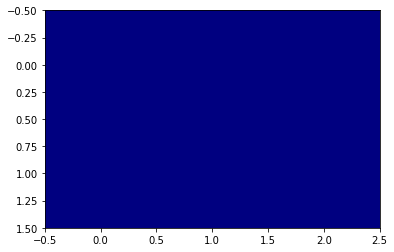

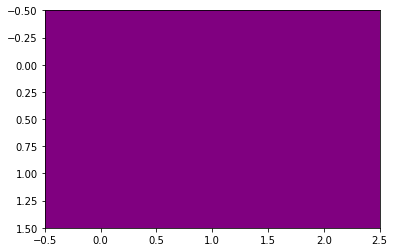

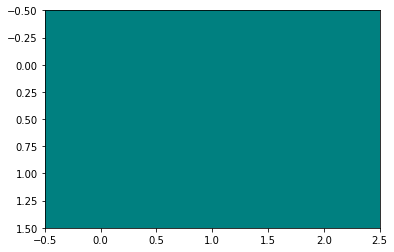

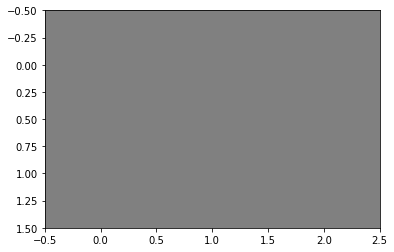

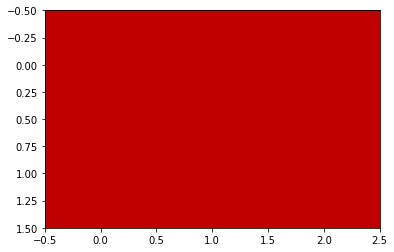

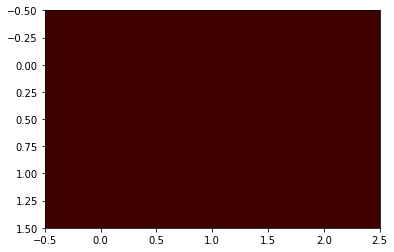

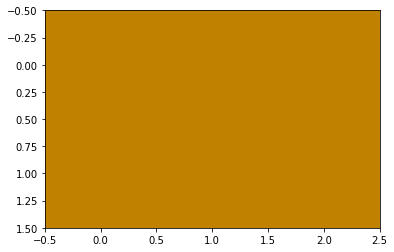

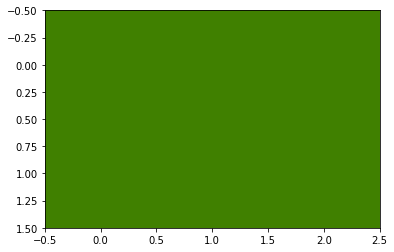

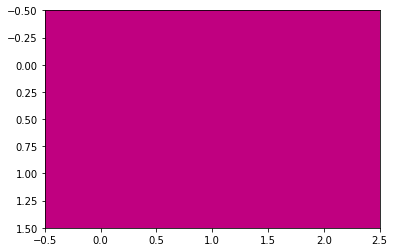

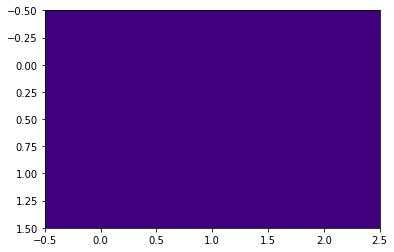

In [74]:
for i in range(len(label_texts)):
    temp = np.ones((2,3,3))
    temp *= loader.cmap[i]
    plt.figure()
    plt.imshow(temp, aspect='auto')